In [276]:
import os
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
from helper import *
import const
from sim import Sim
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.integrate import trapz as integrate
from scipy.integrate import cumtrapz as cumintegrate
from matplotlib.colors import Normalize, LogNorm
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
from functions import interp


In [277]:
time = 10*const.day


In [278]:
rproc = 'strong'

data_rproc = np.load(os.path.join('..', 'rprocess', '%s.npz' % rproc), allow_pickle=True)
data_rproc = SimpleNamespace(**data_rproc)
idx_rproc = np.searchsorted(data_rproc.time, time)
Zmax = 118

if time < data_rproc.time[0]:  print('Warning: time below minimum time in KNe simulations')
if time > data_rproc.time[-1]: print('Warning: time above maximum time in KNe simulations')


In [279]:
Nmax = np.max(data_rproc.ab_iso[idx_rproc])[0][0]
ab_grid = np.zeros((Nmax, Zmax))

for Z in range(Zmax+1):

    A_list, ab_list = data_rproc.ab_iso[idx_rproc, Z]
    for A, ab in zip(A_list, ab_list): ab_grid[A-Z, Z] = ab*A


In [280]:
with open(os.path.join('..', 'NuDat', 'nndc.csv'), 'r') as f: lines = f.readlines()    
stab_grid = np.full((178, 119), False)
for line in lines[1:]:
    line_split = line.split(',')
    if line_split[4] == 'STABLE': 
        Z = int(line_split[0])
        N = int(line_split[1])
        stab_grid[N, Z] = True


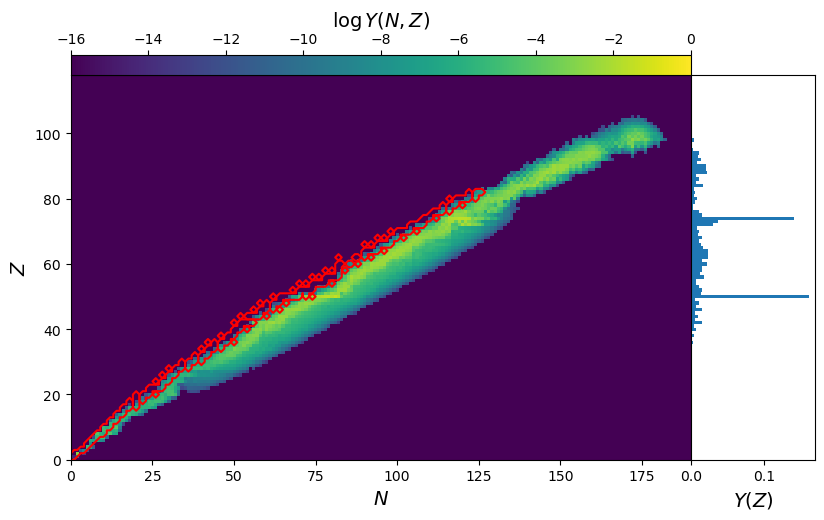

In [281]:
fig, ax1 = plt.subplots(figsize=(8, 8))

im = ax1.imshow(np.log10(ab_grid+1e-20).T, origin='lower', vmin=-16, vmax=0)

ax1.contour(np.arange(178), np.arange(119), stab_grid.T, colors='red', levels=[0, 1])

ax1.set_xlim(0, 190)
ax1.set_ylim(0, 118)

ax1.set_xlabel(r'$N$', fontsize=14)
ax1.set_ylabel(r'$Z$', fontsize=14)

ax2 = ax1.inset_axes([1, 0, 0.2, 1])
ax2.sharey(ax1)
ax2.barh(np.arange(Zmax+1), data_rproc.ab_elem[idx_rproc]*data_rproc.A_avg[idx_rproc], height=1.0, align='center')

ax2.get_yaxis().set_visible(False)
ax2.set_xlabel(r'$Y(Z)$', fontsize=14)

cax = ax1.inset_axes([0, 1, 1, 0.05])
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
cbar.set_label(r'$\log Y(N, Z)$', fontsize=14)
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')


In [282]:
run = 1

data_KNe = np.load(os.path.join('..', 'KNexplosions', 'runhr%d.npz' % run))
data_KNe = SimpleNamespace(**data_KNe)
idx_KNe = np.searchsorted(data_KNe.time, time)

if time < data_KNe.time[0]:  print('Warning: time below minimum time in KNe simulations')
if time > data_KNe.time[-1]: print('Warning: time above maximum time in KNe simulations')

rho = data_KNe.rho_shock[idx_KNe]
temp = data_KNe.temp_shock[idx_KNe]
    
print('Mej: %.3g Msol' % (data_KNe.Mej/const.M_sol))
print('vej: %.3g km/s' % (data_KNe.vej/const.km))
print('n_cgs: %.3g/cc' % (data_KNe.nH_cgm))
print('rho: %.3g g/cc' % rho)
print('T: %.3g K' % temp)
    

Mej: 0.01 Msol
vej: 1.5e+04 km/s
n_cgs: 10/cc
rho: 3.93e-15 g/cc
T: 7.33e+03 K


In [284]:
sim = Sim(ener=1000000, rho=rho, do_iso=False, do_moller=False)

for Zelem in range(1, 99):
    
    ab = data_rproc.ab_elem[idx_rproc, Zelem]
    if ab > 0:
        A_avg = data_rproc.A_avg[idx_rproc, Zelem]
        sim.add_spec(Z=Zelem, A=A_avg, ab=ab)
        
#sim.add_elec(x_e=0.1)

#sim.add_Bturb(Bmag=3e4)
#sim.add_Bco(Bmag=1e4, Bhat=np.array([0, 1, 0]))
        

In [285]:
sim.reset()
while sim.time < 120:
    sim.step()


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/za9132/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/k0/yybwzjk54bg00p8q3ykchsx80000gp/T/ipykernel_5503/4231485743.py", line 3, in <module>
    sim.step()
  File "/Users/za9132/Documents/research/projects/NTE_KNe/thunderstorm/sim.py", line 486, in step
  File "/Users/za9132/Documents/research/projects/NTE_KNe/thunderstorm/sim.py", line 320, in get_event_list
    if self.ener < spec_data.ener_bind_list[i]: continue
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/za9132/Documents/research/projects/NTE_KNe/thunderstorm/sim.py", line 70, in calc_ener_loss
    ener_loss_list[i] = interp(xi, ener_loss_cdf, ener_loss)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/za9132/Documents/research/projects/NTE_KNe/thunderstorm/functions.py", line 28, in interp
    y0[cond_me

Text(0.5, 1.0, '$t=74.09~{\\rm s}$')

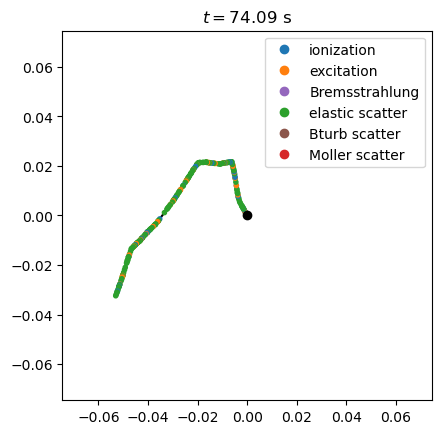

In [286]:
evcat2num = {
    'ionization': 0,
    'excitation': 1,
    'Bremsstrahlung': 4,
    'elastic scatter': 2,
    'Bturb scatter': 5,
    'Moller scatter': 3
}

x_list, y_list = np.array(sim.ev_list.coord)[:, X], np.array(sim.ev_list.coord)[:, Y]
color_list = ['C%d'%evcat2num[cat] for cat in sim.ev_list.cat]

unit = const.AU
plt.plot(0, 0, color='black', marker='o')
plt.scatter(x_list/unit, y_list/unit, marker='.', c=color_list)
plt.plot(np.concatenate(([0], x_list))/unit, np.concatenate(([0], y_list))/unit, color='black', zorder=-1)

rmax = np.max(np.sqrt(x_list**2+y_list**2))/unit
plt.xlim(-1.2*rmax, 1.2*rmax)
plt.ylim(-1.2*rmax, 1.2*rmax)

plt.gca().set_aspect(True)

cust_lines = [Line2D([0], [0], marker='o', linestyle='', color='C%d'%num, label=label) for (label, num) in evcat2num.items()]
plt.legend(handles=cust_lines)

plt.title(r'$t=%.2f~{\rm s}$'%sim.time)


Text(0.5, 0, '$z$ [AU]')

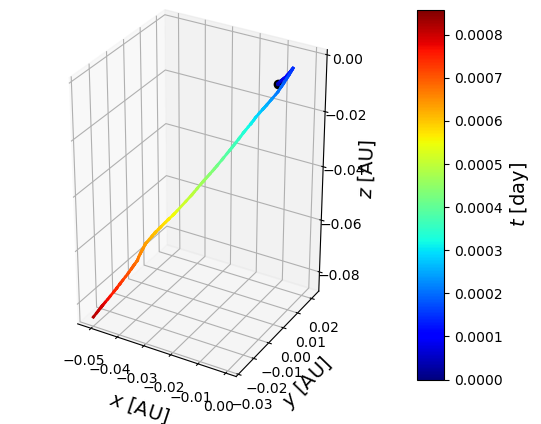

In [288]:
ax = plt.figure().add_subplot(projection='3d')

unit_l = const.AU
unit_t = const.day
unit_e = 1000
var_color = 'time'

nstep = len(sim.ev_list.time)
nseg = min(nstep, 256)
skip = int(nstep/nseg)

cmap = mpl.colormaps['jet']

if var_color == 'time':
    norm = Normalize(0, sim.ev_list.time[-1]/unit_t)
    color_list = cmap(norm(np.array(sim.ev_list.time)[::skip]/unit_t))
elif var_color == 'ener':
    norm = Normalize(sim.ev_list.ener[-1]/unit_e, sim.ener_init/unit_e)
    color_list = cmap(norm(np.array(sim.ev_list.ener)[::skip]/unit_e))
    
x_list, y_list, z_list = np.array(sim.ev_list.coord)[:, 0], np.array(sim.ev_list.coord)[:, 1], np.array(sim.ev_list.coord)[:, 2]

ax.plot([0], [0], [0], color='black', marker='o')
ax.plot([0, x_list[0]/unit_l], [0, y_list[0]/unit_l], [0, z_list[0]/unit_l], color=color_list[0], lw=2)
for i in range(nseg):
    ax.plot(x_list[i*skip:(i+1)*skip+1]/unit_l, y_list[i*skip:(i+1)*skip+1]/unit_l, z_list[i*skip:(i+1)*skip+1]/unit_l, color=color_list[i], lw=2)

ax.set_aspect('equal')

sm = ScalarMappable(norm, cmap=cmap)
cax = ax.inset_axes([1.1, 0, 0.075, 1])
cbar = plt.colorbar(sm, cax=cax)

if var_color == 'time':
    cbar.set_label(r'$t$ [${\rm day}$]', fontsize=14)
elif var_color == 'ener':
    cbar.set_label(r'$E$ [${\rm keV}$]', fontsize=14)

ax.set_xlabel(r'$x$ [AU]', fontsize=14)
ax.set_ylabel(r'$y$ [AU]', fontsize=14)
ax.set_zlabel(r'$z$ [AU]', fontsize=14)


Text(0, 0.5, 'number of interactions')

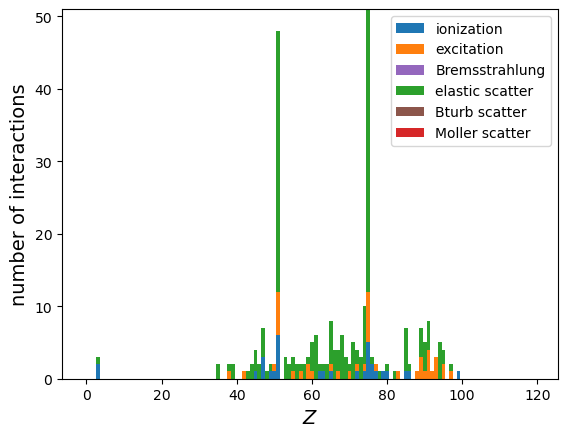

In [289]:
ncat = 6
ev_hist = np.zeros((ncat, Zmax+2), dtype=int)

for cat, Z in zip(sim.ev_list.cat, sim.ev_list.Z):
    if Z==None: Z = 0
    ev_hist[evcat2num[cat], Z+1] += 1
    
for i in range(ncat):
    ev_hist_cum = np.sum(ev_hist[:i], axis=0)
    plt.bar(np.arange(Zmax+2), ev_hist[i], width=1, bottom=ev_hist_cum);
    
cust_lines = [Patch(facecolor='C%d'%num, label=label) for (label, num) in evcat2num.items()]
plt.legend(handles=cust_lines)

plt.xlabel(r'$Z$', fontsize=14)
plt.ylabel(r'number of interactions', fontsize=14)


Text(0, 0.5, '$E$ [${\\rm keV}$]')

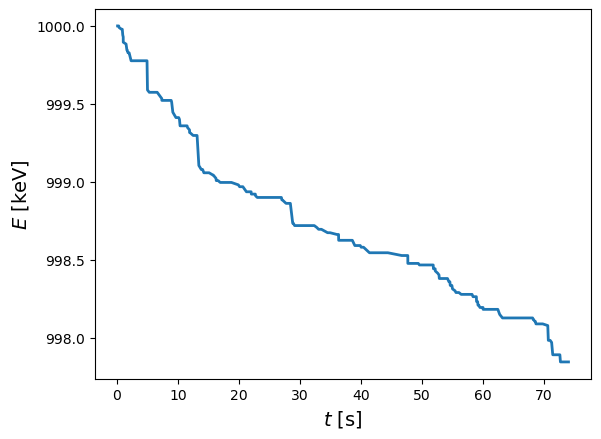

In [290]:
plt.plot(sim.ev_list.time, np.array(sim.ev_list.ener)/1e3, lw=2)

plt.xlabel(r'$t$ [${\rm s}$]', fontsize=14)
plt.ylabel(r'$E$ [${\rm keV}$]', fontsize=14)


In [233]:
sim.ev_list.time

[0.20985676514675036,
 0.8480862669374459,
 1.0282463386024372,
 1.0649764156105308,
 1.0739875470671454,
 2.2109527910121396,
 2.6529614453241575,
 2.6723893749423118,
 3.3880553578779633,
 3.4633896430822335,
 3.720715844042717,
 4.847760226119665,
 4.871789569846112,
 4.91911444275308,
 5.028173342831151,
 5.226820813954222,
 5.525831177770918,
 5.603369075424828,
 5.615200622498546,
 6.3665064974628,
 6.437430252753656,
 6.734982039926806,
 6.755321510028118,
 6.784548720191488,
 7.053283249785139,
 7.066080914614151,
 7.157636237363338,
 7.169131913908029,
 7.258855200199309,
 8.097442191816649,
 8.202573225889891,
 8.245495851935992,
 8.260931953189985,
 8.338567152179724,
 8.343933649827719,
 8.917659577226205,
 8.952723856505106,
 9.246451764847734,
 9.38405033243384,
 9.491303427058105,
 9.84356460868903,
 9.864797322520477,
 9.909170134101808,
 9.90927567470202,
 10.045140335114395,
 10.295612097105195,
 10.37179993442639,
 10.686159547370057,
 10.716767170651693,
 10.7296869